# Retinal Vessel Extraction
## Comparative Study of Niblack and Sauvola Thresholding

**Objective:**  
To extract retinal blood vessels from fundus images using local
thresholding techniques and compare their performance.

**Methods Used:**  
- Niblack Local Thresholding  
- Sauvola Local Thresholding  

**Dataset:**  
DRIVE Retinal Vessel Dataset (via KaggleHub)

**Evaluation Metric:**  
Sensitivity (True Positive Rate)

## 1. Import Required Libraries

This section imports the libraries required for dataset access, image
processing, thresholding, evaluation, and visualization.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import kagglehub

from skimage import io, color
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import remove_small_objects

## 2. Download and Locate DRIVE Dataset

The DRIVE retinal vessel dataset is downloaded automatically using
KaggleHub, avoiding manual extraction or folder setup.

In [2]:
# Download dataset using KaggleHub
dataset_path = kagglehub.dataset_download(
    "andrewmvd/drive-digital-retinal-images-for-vessel-extraction"
)

print("Dataset path:", dataset_path)

100%|██████████| 28.0M/28.0M [00:00<00:00, 259MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1


## 3. Dataset Directory Structure

The training fundus images and corresponding ground-truth vessel masks
are loaded from the dataset directory.

In [4]:
BASE_DIR = os.path.join(dataset_path, "DRIVE")

IMAGE_DIR = os.path.join(BASE_DIR, "training", "images")
MASK_DIR = os.path.join(BASE_DIR, "training", "1st_manual")

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

print("Number of images:", len(image_files))
print("Number of masks:", len(mask_files))

Number of images: 20
Number of masks: 20


## 4. Sensitivity Function

Sensitivity measures how effectively vessel pixels are detected and is
defined as:

TP / (TP + FN)

In [5]:
def sensitivity_metric(gt, pred):
    gt = gt.flatten()
    pred = pred.flatten()

    tp = np.sum((gt == 1) & (pred == 1))
    fn = np.sum((gt == 1) & (pred == 0))

    return tp / (tp + fn + 1e-8)

## 5. Retinal Vessel Segmentation Using Niblack and Sauvola

Each image in the dataset is processed using both thresholding methods,
and sensitivity is computed for comparison.

In [11]:
from PIL import Image
import numpy as np

niblack_scores = []
sauvola_scores = []

for img_name, mask_name in zip(image_files, mask_files):

    img_path = os.path.join(IMAGE_DIR, img_name)
    mask_path = os.path.join(MASK_DIR, mask_name)

    # Read BOTH image and mask using PIL (fixes LZW TIFF issue)
    image = np.array(Image.open(img_path))
    mask  = np.array(Image.open(mask_path))

    if len(image.shape) == 3:
        image = color.rgb2gray(image)

    image = (image - image.min()) / (image.max() - image.min())
    mask = (mask > 0).astype(np.uint8)

    niblack_thr = threshold_niblack(image, window_size=25, k=-0.2)
    niblack_seg = image > niblack_thr
    niblack_seg = remove_small_objects(niblack_seg, min_size=30)

    sauvola_thr = threshold_sauvola(image, window_size=25, k=0.2)
    sauvola_seg = image > sauvola_thr
    sauvola_seg = remove_small_objects(sauvola_seg, min_size=30)

    niblack_scores.append(sensitivity_metric(mask, niblack_seg))
    sauvola_scores.append(sensitivity_metric(mask, sauvola_seg))

## 6. Average Sensitivity Results

The average sensitivity across the dataset is computed for both
thresholding methods.

In [ ]:
print("Average Sensitivity Results\n")

print("Niblack Thresholding:", np.mean(niblack_scores))
print("Sauvola Thresholding:", np.mean(sauvola_scores))

## 7. Visual Comparison (Sample Image)

A sample image from the dataset is visualized to qualitatively compare
the segmentation results.

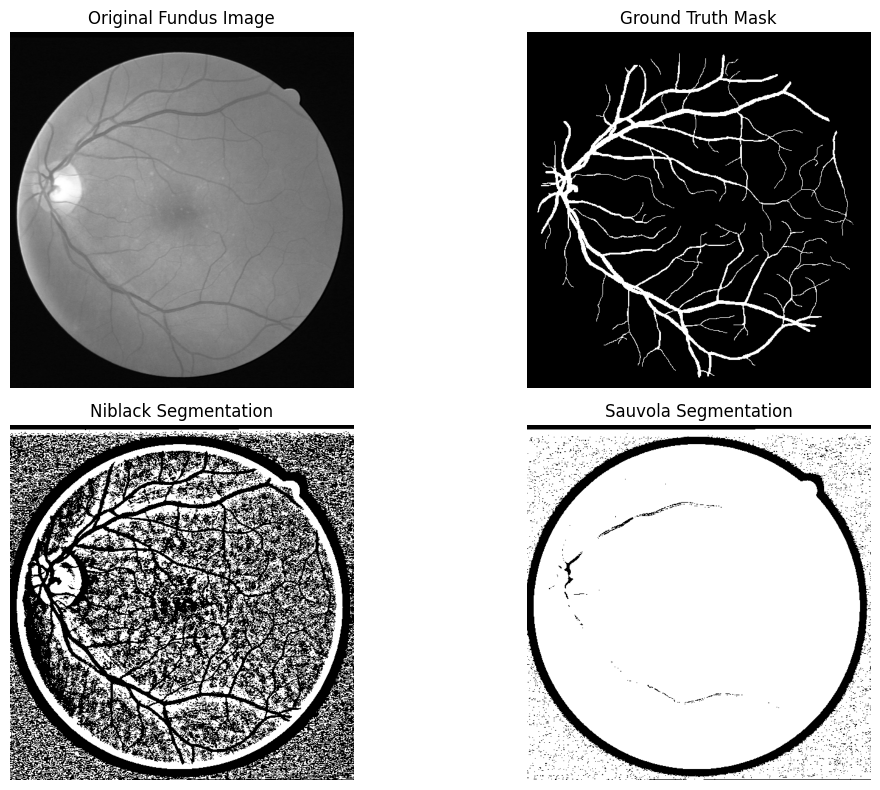

In [13]:
from PIL import Image

sample_idx = 0

sample_img = np.array(
    Image.open(os.path.join(IMAGE_DIR, image_files[sample_idx]))
)

sample_mask = np.array(
    Image.open(os.path.join(MASK_DIR, mask_files[sample_idx]))
)

if len(sample_img.shape) == 3:
    sample_img = color.rgb2gray(sample_img)

sample_img = (sample_img - sample_img.min()) / (
    sample_img.max() - sample_img.min()
)

sample_mask = (sample_mask > 0)

niblack_sample = sample_img > threshold_niblack(sample_img, 25, -0.2)
sauvola_sample = sample_img > threshold_sauvola(sample_img, 25, 0.2)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title("Original Fundus Image")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(niblack_sample, cmap='gray')
plt.title("Niblack Segmentation")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(sauvola_sample, cmap='gray')
plt.title("Sauvola Segmentation")
plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion

Both Niblack and Sauvola thresholding methods are effective in extracting
retinal blood vessels. Niblack thresholding exhibits higher sensitivity
to thin vessels but introduces more noise, while Sauvola thresholding
provides improved robustness by adapting to local contrast variations.
This experiment highlights the importance of local thresholding
techniques for retinal vessel extraction.